# Dales Law

In [ ]:
# Cell 2 — Imports and device
import os, json, time, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, Markdown

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

UPLOADED_SCRIPT_PATH = "./psychrnn_perceptualdiscrimination_noise_comparison.py"
if Path(UPLOADED_SCRIPT_PATH).exists():
    display(Markdown(f"**Found uploaded script:** `{UPLOADED_SCRIPT_PATH}`"))
else:
    display(Markdown(f"**No uploaded script found at** `{UPLOADED_SCRIPT_PATH}`"))


Device: cuda


**No uploaded script found at** `./psychrnn_perceptualdiscrimination_noise_comparison.py`

In [ ]:
# Cell 4 — Utilities
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def savefig(fig, path, dpi=150):
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    print("Saved:", path)


In [ ]:
# Cell 6 — Task implementation
def generate_batch(batch_size, T, coherence, stim_std=1.0, input_dim=2, device='cpu'):
    """
    Generate PerceptualDiscrimination batch.
    Each trial: choose label {0,1}; add coherence to the chosen channel across all timesteps.
    Returns:
      x: torch.Tensor (batch, T, input_dim)
      y: torch.LongTensor (batch,)
    """
    labels = np.random.choice([0,1], size=(batch_size,))
    x = np.random.randn(batch_size, T, input_dim) * stim_std
    for i, lab in enumerate(labels):
        x[i, :, lab] += coherence
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    y_t = torch.tensor(labels, dtype=torch.long, device=device)
    return x_t, y_t


In [ ]:
# Cell 8 — Model class
class RNNWithGateDale(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=2,
                 rec_noise_std=0.0, gate=True, dale=True, dale_exc_frac=0.8, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.rec_noise_std = rec_noise_std
        self.gate = gate
        self.dale = dale
        self.device = device

        # input linear as parameters for faster custom compute
        self.W_in = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
        self.b_in = nn.Parameter(torch.zeros(hidden_dim))

        # recurrent raw weights; we will enforce Dale's law via transformation
        self.W_rec_raw = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * (1.0/np.sqrt(hidden_dim)))
        self.b_rec = nn.Parameter(torch.zeros(hidden_dim))

        # output layer
        self.W_out = nn.Linear(hidden_dim, output_dim)

        # gating params
        if self.gate:
            self.W_gate = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
            self.b_gate = nn.Parameter(torch.zeros(hidden_dim))

        # dale sign buffer
        if self.dale:
            n_exc = int(round(dale_exc_frac * hidden_dim))
            signs = np.array([1]*n_exc + [-1]*(hidden_dim-n_exc))
            np.random.shuffle(signs)
            self.register_buffer('dale_sign', torch.tensor(signs, dtype=torch.float32).to(device))
        else:
            self.register_buffer('dale_sign', torch.ones(hidden_dim, dtype=torch.float32).to(device))

        self.activation = torch.tanh

    def effective_Wrec(self):
        # make columns non-negative then multiply by sign
        W_abs = torch.abs(self.W_rec_raw)  # all >=0
        # apply sign along columns (outgoing weights)
        W = W_abs * self.dale_sign.unsqueeze(0)
        return W

    def forward(self, x, return_hidden=False):
        # x: (batch, T, input_dim)
        batch, T, _ = x.size()
        h = torch.zeros(batch, self.hidden_dim, device=x.device)
        hs = []
        W_rec = self.effective_Wrec()
        for t in range(T):
            xt = x[:, t, :]  # (batch, input_dim)
            inp = torch.matmul(xt, self.W_in.t()) + self.b_in  # (batch, hidden)
            if self.gate:
                g = torch.sigmoid(torch.matmul(xt, self.W_gate.t()) + self.b_gate)  # (batch, hidden)
                inp = inp * g
            rec = torch.matmul(h, W_rec.t()) + self.b_rec  # (batch, hidden)
            h = self.activation(inp + rec)
            if self.rec_noise_std and self.training:
                h = h + torch.randn_like(h) * float(self.rec_noise_std)
            hs.append(h.unsqueeze(1))
        hs = torch.cat(hs, dim=1)  # (batch, T, hidden)
        logits = self.W_out(hs[:, -1, :])  # last timestep decision
        if return_hidden:
            return logits, hs
        return logits


In [ ]:
# Cell 10 — Evaluation functions
import torch.nn.functional as F

def compute_accuracy(model, coherence, n_trials=512, batch_size=128, T=40, stim_std=1.0, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        while total < n_trials:
            b = min(batch_size, n_trials - total)
            x, y = generate_batch(b, T, coherence, stim_std=stim_std, device=device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += b
    return correct / total

def psychometric_curve(model, coherences, n_trials_each=600, batch_size=128, T=40, stim_std=1.0, device='cpu'):
    accs = []
    for c in coherences:
        acc = compute_accuracy(model, c, n_trials=n_trials_each, batch_size=batch_size, T=T, stim_std=stim_std, device=device)
        accs.append(acc)
    return np.array(accs)

def fit_consistent_pca(models, names, coherence=0.4, T=40, trials_per_model=12, device='cpu'):
    """
    Fit PCA on a pooled set of hidden-states across models/trials to ensure consistent projection.
    Returns fitted PCA object.
    """
    all_h = []
    with torch.no_grad():
        for name, model in zip(names, models):
            model.eval()
            for _ in range(trials_per_model):
                x, y = generate_batch(1, T, coherence, device=device)
                _, hs = model(x, return_hidden=True)
                all_h.append(hs[0].cpu().numpy())  # (T, hidden)
    all_h_concat = np.concatenate(all_h, axis=0)  # (trials*T, hidden)
    pca = PCA(n_components=3)
    pca.fit(all_h_concat)
    return pca

def pca_traj_in_pca(model, pca, coherence=0.4, T=40, device='cpu'):
    model.eval()
    with torch.no_grad():
        x, y = generate_batch(1, T, coherence, device=device)
        _, hs = model(x, return_hidden=True)
        h = hs[0].cpu().numpy()  # T x hidden
    traj = pca.transform(h)  # T x 3
    return traj, int(y.cpu().numpy()[0]), traj


In [ ]:
# Cell 12 — Training function
def train_model(
    seed=0,
    training_iters=20000,
    batch_size=128,
    T=40,
    hidden_dim=128,
    lr=3e-4,
    rec_noise=0.0,
    gate=True,
    dale=True,
    dale_exc_frac=0.8,
    start_coh=0.6,
    min_coh=0.1,
    coh_step=0.1,
    mode='baseline',   # 'baseline' or 'curriculum'
    eval_interval=500,
    target_acc=0.85,
    outdir='out_run',
    device='cpu',
    verbose=True
):
    set_seed(seed)
    os.makedirs(outdir, exist_ok=True)

    model = RNNWithGateDale(input_dim=2, hidden_dim=hidden_dim, output_dim=2,
                            rec_noise_std=rec_noise, gate=gate, dale=dale,
                            dale_exc_frac=dale_exc_frac, device=device).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    losses = []
    psych_history = []
    eval_coherences = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
    coher = float(start_coh)

    it = 0
    while it < training_iters:
        model.train()
        x, y = generate_batch(batch_size, T, coher, device=device)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
        it += 1

        if it % eval_interval == 0:
            val_acc = compute_accuracy(model, coher, n_trials=512, batch_size=batch_size, T=T, device=device)
            psych = psychometric_curve(model, eval_coherences, n_trials_each=300, batch_size=batch_size, T=T, device=device)
            psych_history.append({"iter": int(it), "coherence": float(coher), "val_acc": float(val_acc), "psych": psych.tolist()})
            if verbose:
                print(f"[{outdir}] iter {it} | coh {coher:.2f} | loss {loss.item():.4f} | val_acc {val_acc:.3f}")
            # curriculum step
            if mode == 'curriculum' and val_acc >= target_acc and (coher - coh_step) >= min_coh:
                coher = max(min_coh, coher - coh_step)
                if verbose:
                    print(f"  -> Curriculum: lowered coherence to {coher:.2f} at iter {it}")

    final_psych = psychometric_curve(model, eval_coherences, n_trials_each=600, batch_size=batch_size, T=T, device=device)

    torch.save(model.state_dict(), os.path.join(outdir, 'model_state.pt'))

    results = {
        "losses": list(map(float, losses)),
        "psych_history": psych_history,
        "final_psych": list(map(float, final_psych)),
        "eval_coherences": list(map(float, eval_coherences)),
        "params": {
            "seed": int(seed), "training_iters": int(training_iters), "batch_size": int(batch_size),
            "T": int(T), "hidden_dim": int(hidden_dim), "lr": float(lr),
            "rec_noise": float(rec_noise), "gate": bool(gate), "dale": bool(dale),
            "start_coh": float(start_coh), "min_coh": float(min_coh), "coh_step": float(coh_step),
            "mode": mode
        }
    }
    with open(os.path.join(outdir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=2)
    return model, results


In [ ]:
HIDDEN_DIM = 128         # model size
TRAIN_ITERS = 10000      # recommended for final; set 2000-5000 for quick demo
BATCH_SIZE = 128
T = 40
LR = 3e-4
REC_NOISE_NOISY = 0.1
SEED = 0
DEVICE = device

OUT_ROOT = Path("out_full_experiment")
OUT_ROOT.mkdir(exist_ok=True)

# If you want a fast demo locally (comment/uncomment):
# TRAIN_ITERS = 2000


In [ ]:
experiments = {
    "baseline": {"rec_noise": 0.0, "start_coh": 0.2, "mode": "baseline"},
    "noisy":    {"rec_noise": REC_NOISE_NOISY, "start_coh": 0.2, "mode": "baseline"},
    "curriculum":{"rec_noise": 0.0, "start_coh": 0.8, "mode": "curriculum"}
}

models = {}
results = {}

for name, cfg in experiments.items():
    outdir = str(OUT_ROOT / name)
    print("\n=== RUN:", name, "->", outdir)
    model, res = train_model(
        seed=SEED,
        training_iters=TRAIN_ITERS,
        batch_size=BATCH_SIZE,
        T=T,
        hidden_dim=HIDDEN_DIM,
        lr=LR,
        rec_noise=cfg["rec_noise"],
        gate=True,                       # FULL version: gating ON
        dale=True,                       # FULL version: Dale's law ON
        dale_exc_frac=0.8,
        start_coh=cfg["start_coh"],
        min_coh=0.1,
        coh_step=0.1,
        mode=cfg["mode"],
        eval_interval=200,
        target_acc=0.88,
        outdir=outdir,
        device=DEVICE,
        verbose=True
    )
    models[name] = model
    results[name] = res
    print("Saved results for", name, "->", outdir)



=== RUN: baseline -> out_full_experiment/baseline
[out_full_experiment/baseline] iter 200 | coh 0.20 | loss 0.6728 | val_acc 0.559
[out_full_experiment/baseline] iter 400 | coh 0.20 | loss 0.6611 | val_acc 0.555
[out_full_experiment/baseline] iter 600 | coh 0.20 | loss 0.8086 | val_acc 0.475
[out_full_experiment/baseline] iter 800 | coh 0.20 | loss 0.6974 | val_acc 0.504
[out_full_experiment/baseline] iter 1000 | coh 0.20 | loss 0.6709 | val_acc 0.490
[out_full_experiment/baseline] iter 1200 | coh 0.20 | loss 0.6815 | val_acc 0.553
[out_full_experiment/baseline] iter 1400 | coh 0.20 | loss 0.6771 | val_acc 0.547
[out_full_experiment/baseline] iter 1600 | coh 0.20 | loss 0.6817 | val_acc 0.619
[out_full_experiment/baseline] iter 1800 | coh 0.20 | loss 0.6949 | val_acc 0.498
[out_full_experiment/baseline] iter 2000 | coh 0.20 | loss 0.6679 | val_acc 0.543
[out_full_experiment/baseline] iter 2200 | coh 0.20 | loss 0.6706 | val_acc 0.551
[out_full_experiment/baseline] iter 2400 | coh 0.20

In [ ]:
# # Cell 15 — run the three main experiments (this may take a while on CPU)
# experiments = {
#     # "baseline": {"rec_noise": 0.0, "start_coh": 0.2, "mode": "baseline"},
#     # "noisy":    {"rec_noise": REC_NOISE_NOISY, "start_coh": 0.2, "mode": "baseline"},
#     "curriculum":{"rec_noise": 0.0, "start_coh": 0.8, "mode": "curriculum"}
# }

# # models = {}
# # results = {}

# for name, cfg in experiments.items():
#     outdir = str(OUT_ROOT / name)
#     print("\n=== RUN:", name, "->", outdir)
#     model, res = train_model(
#         seed=SEED,
#         training_iters=TRAIN_ITERS/2,
#         batch_size=BATCH_SIZE,
#         T=T,
#         hidden_dim=HIDDEN_DIM,
#         lr=LR,
#         rec_noise=cfg["rec_noise"],
#         gate=True,                       # FULL version: gating ON
#         dale=True,                       # FULL version: Dale's law ON
#         dale_exc_frac=0.8,
#         start_coh=cfg["start_coh"],
#         min_coh=0.1,
#         coh_step=0.05,
#         mode=cfg["mode"],
#         eval_interval=500,
#         target_acc=0.88,
#         outdir=outdir,
#         device=DEVICE,
#         verbose=True
#     )
#     models[name] = model
#     results[name] = res
#     print("Saved results for", name, "->", outdir)


Saved: out_full_experiment/loss_curves.png
Saved: out_full_experiment/psych_curves.png


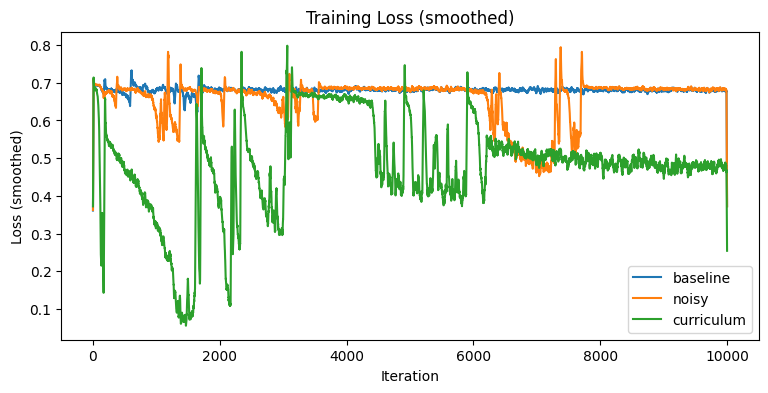

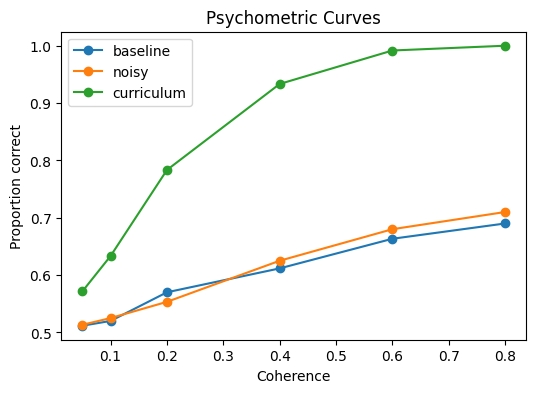

In [ ]:
# Cell 17 — Plot training losses and psychometric curves
def plot_loss_curves(results_dict, outpath):
    plt.figure(figsize=(9,4))
    for name, res in results_dict.items():
        losses = np.array(res["losses"])
        if len(losses) > 20:
            smooth = np.convolve(losses, np.ones(20)/20, mode='same')
        else:
            smooth = losses
        plt.plot(smooth, label=name)
    plt.xlabel("Iteration"); plt.ylabel("Loss (smoothed)"); plt.title("Training Loss (smoothed)")
    plt.legend()
    savefig(plt, outpath)

def plot_psychcurves(results_dict, outpath):
    plt.figure(figsize=(6,4))
    for name, res in results_dict.items():
        coh = np.array(res["eval_coherences"])
        psych = np.array(res["final_psych"])
        plt.plot(coh, psych, '-o', label=name)
    plt.xlabel("Coherence"); plt.ylabel("Proportion correct"); plt.title("Psychometric Curves")
    plt.legend()
    savefig(plt, outpath)

plot_loss_curves(results, OUT_ROOT / "loss_curves.png")
plot_psychcurves(results, OUT_ROOT / "psych_curves.png")


Saved: out_full_experiment/pca_trajectories.png


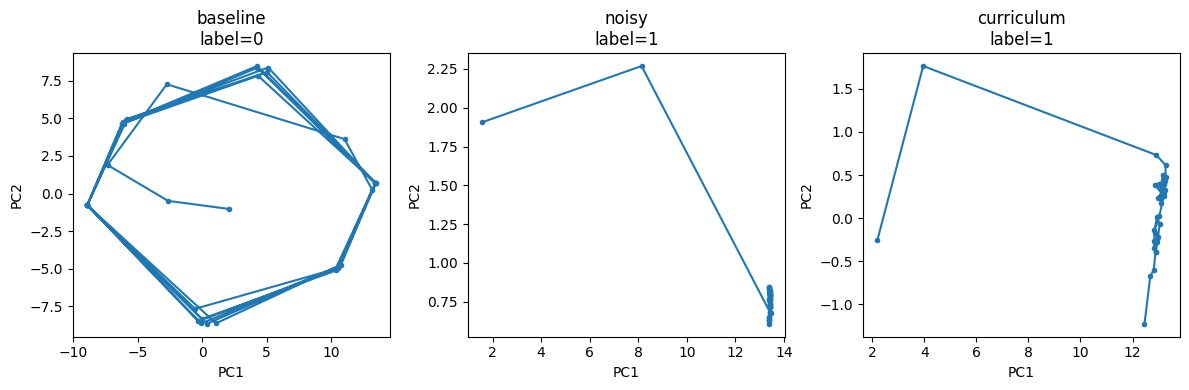

In [ ]:
# Cell 19 — PCA analysis and plotting
pca = fit_consistent_pca(list(models.values()), list(models.keys()), coherence=0.4, T=T, trials_per_model=12, device=DEVICE)

plt.figure(figsize=(12,4))
for i, name in enumerate(models.keys()):
    traj, label, _ = pca_traj_in_pca(models[name], pca, coherence=0.4, T=T, device=DEVICE)
    ax = plt.subplot(1, len(models), i+1)
    ax.plot(traj[:,0], traj[:,1], '-o', markersize=3)
    ax.set_title(f"{name}\nlabel={label}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.tight_layout()
savefig(plt, OUT_ROOT / "pca_trajectories.png")
plt.show()


In [ ]:
# Cell 21 — Save summary
summary_lines = []
for name, res in results.items():
    final_psych = np.array(res["final_psych"])
    coh = np.array(res["eval_coherences"])
    idx = np.where(final_psych >= 0.75)[0]
    thr = float(coh[idx[0]]) if len(idx)>0 else float('nan')
    summary_lines.append(f"{name}: threshold_75 = {thr}, final_psych = {np.round(final_psych,3).tolist()}")

summary_text = "\n".join(summary_lines)
print(summary_text)
(OUT_ROOT / "results_summary.txt").write_text(summary_text)

# Save parameters and runtimes
meta = {
    "experiments": {k: v["params"] if "params" in v else results[k]["params"] for k,v in results.items()},
    "seed": SEED,
    "device": str(DEVICE)
}
with open(OUT_ROOT / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved summary and meta to", OUT_ROOT)


baseline: threshold_75 = nan, final_psych = [0.512, 0.52, 0.57, 0.612, 0.663, 0.69]
noisy: threshold_75 = nan, final_psych = [0.513, 0.525, 0.553, 0.625, 0.68, 0.71]
curriculum: threshold_75 = 0.2, final_psych = [0.572, 0.633, 0.783, 0.933, 0.992, 1.0]
Saved summary and meta to out_full_experiment


In [ ]:
!zip -r ./Dales_Law.zip ./out_full_experiment/


  adding: out_full_experiment/ (stored 0%)
  adding: out_full_experiment/meta.json (deflated 79%)
  adding: out_full_experiment/baseline/ (stored 0%)
  adding: out_full_experiment/baseline/model_state.pt (deflated 10%)
  adding: out_full_experiment/baseline/results.json (deflated 66%)
  adding: out_full_experiment/pca_trajectories.png (deflated 7%)
  adding: out_full_experiment/noisy/ (stored 0%)
  adding: out_full_experiment/noisy/model_state.pt (deflated 10%)
  adding: out_full_experiment/noisy/results.json (deflated 66%)
  adding: out_full_experiment/curriculum/ (stored 0%)
  adding: out_full_experiment/curriculum/model_state.pt (deflated 10%)
  adding: out_full_experiment/curriculum/results.json (deflated 65%)
  adding: out_full_experiment/results_summary.txt (deflated 48%)
  adding: out_full_experiment/psych_curves.png (deflated 7%)
  adding: out_full_experiment/loss_curves.png (deflated 4%)


Saved: out_full_experiment/loss_curves.png
Saved: out_full_experiment/psych_curves.png


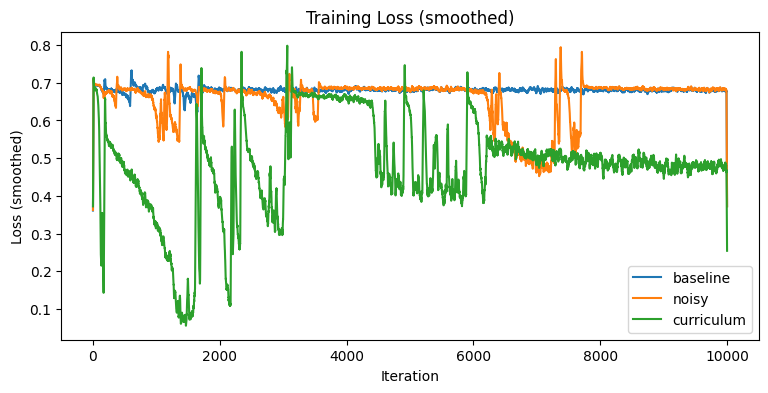

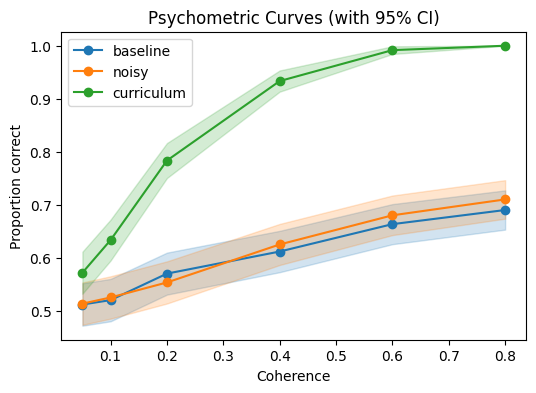

In [ ]:
# Cell 17 — Plot training losses and psychometric curves
def plot_loss_curves(results_dict, outpath):
    plt.figure(figsize=(9,4))
    for name, res in results_dict.items():
        losses = np.array(res["losses"])
        if len(losses) > 20:
            smooth = np.convolve(losses, np.ones(20)/20, mode='same')
        else:
            smooth = losses
        plt.plot(smooth, label=name)
    plt.xlabel("Iteration"); plt.ylabel("Loss (smoothed)"); plt.title("Training Loss (smoothed)")
    plt.legend()
    savefig(plt, outpath)

def plot_psychcurves(results_dict, outpath, n_trials=600):
    plt.figure(figsize=(6,4))
    for name, res in results_dict.items():
        coh = np.array(res["eval_coherences"])
        psych = np.array(res["final_psych"])

        # --- START CHANGE: Calculate Confidence Intervals ---
        # Standard Error (SE) for a proportion: sqrt( p*(1-p) / n )
        se = np.sqrt(psych * (1 - psych) / n_trials)

        # 95% Confidence Interval (approx 1.96 * SE)
        ci_upper = np.clip(psych + 1.96 * se, 0, 1)
        ci_lower = np.clip(psych - 1.96 * se, 0, 1)

        # Plot the mean line
        line = plt.plot(coh, psych, '-o', label=name)
        color = line[0].get_color() # Match the shade color to the line color

        # Add the shaded error band
        plt.fill_between(coh, ci_lower, ci_upper, color=color, alpha=0.2)
        # --- END CHANGE ---

    plt.xlabel("Coherence"); plt.ylabel("Proportion correct"); plt.title("Psychometric Curves")
    plt.legend()
    savefig(plt, outpath)

plot_loss_curves(results, OUT_ROOT / "loss_curves.png")
plot_psychcurves(results, OUT_ROOT / "psych_curves.png")